# Pipeline for High-z Radio Galaxies 30: Distribution of transformed features

In this notebook, we want to plot distributions (histograms) of transformed features.  
This would depend on the model and on the used dataset/area from which features are retrieved.

In [1]:
%matplotlib inline
# Static plots
#%matplotlib ipympl
# Interactive plots
import copy
import numpy as np
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.patheffects as mpe
import sklearn.pipeline
import colorcet as cc
import cmasher as cmr
from pycaret import classification as pyc
from pycaret import regression as pyr
import pandas as pd
import shap
import fasttreeshap

In [2]:
mpl.rcdefaults()

In [3]:
pe1            = [mpe.Stroke(linewidth=5.0, foreground='black'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]
pe2            = [mpe.Stroke(linewidth=3.0, foreground='white'),
                  mpe.Stroke(foreground='white', alpha=1),
                  mpe.Normal()]

In [4]:
def get_final_column_names(pycaret_pipeline, sample_df):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        for (name, method) in pycaret_pipeline.named_steps.items():
            if method != 'passthrough' and name != 'trained_model':
                print(f'Running {name}')
                sample_df = method.transform(sample_df)
        return sample_df.columns.tolist()
    else:
        try:
            for (name, method) in pyr.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()
        except:
            for (name, method) in pyc.get_config('prep_pipe').named_steps.items():
                if method != 'passthrough' and name != 'trained_model':
                    print(f'Running {name}')
                    sample_df = method.transform(sample_df)
            return sample_df.columns.tolist()

In [5]:
def get_base_estimators_names(pycaret_pipeline):
    if isinstance(pycaret_pipeline, sklearn.pipeline.Pipeline):
        estimators  = pycaret_pipeline['trained_model'].estimators
    else:
        estimators  = pycaret_pipeline.estimators

    estimators_list = [estimator[0] for estimator in estimators]
    return estimators_list

---

In [6]:
save_plot_flag      = False
load_models_flag    = True
use_zeroth_model    = False  # Initial model to discriminate between star and non-star objects
use_second_z_model  = True

### Load data

In [7]:
cat_path            = '../../Catalogs/'  # relative path to the same directory

In [8]:
used_area           = 'S82'  # can be 'S82', 'HETDEX', 'COSMOS'
HETDEX_subset       = 'Validation'  # Full, Validation, Training, Test, Test+Train, Val+Unknown

In [9]:
file_S82            = 'CatWISE2020_S82_VLASS_VLAS82_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_SDSS_DR16_5sigma_imp.h5'
file_HETDEX         = 'CatWISE2020_VLASS_LOFAR_PS1_GALEX_TGSS_XMM_2MASS_MILLIQUAS_7_4d_ALLWISE_LOLSS_SDSS_DR16_5sigma_imp.h5'
file_COSMOS         = 'CatWISE2020_COSMOS_MILLIQUAS_7_4d_COSMOSVLA3_PS1_GALEX_TGSS_VLASS_XMM_2MASS_ALLWISE_SDSS_DR16_5sigma_imp.h5'

file_name_dict      = {'S82': file_S82, 'HETDEX': file_HETDEX, 'COSMOS': file_COSMOS}
file_name           = file_name_dict[used_area]

In [10]:
feats_2_disc_S82    = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Fint_VLAS82', 'Stotal_TGSS', 'FEP', 'W1mag', 'W2mag']
feats_2_disc_HETDEX = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Sint_LOFAR', 'Stotal_TGSS', 'FEP', 'TotalFlux_LoLSS', 'W1mag', 'W2mag']
feats_2_disc_COSMOS = ['objID', 'RA_MILLI', 'DEC_MILLI', 'X_ray_detect', 'Total_flux_VLASS',\
                     'Stotal_TGSS', 'FEP', 'Flux_COSMOSVLA3', 'W1mag', 'W2mag']

feats_2_disc        = {'S82': feats_2_disc_S82, 'HETDEX': feats_2_disc_HETDEX, 'COSMOS': feats_2_disc_COSMOS}
features_2_discard  = feats_2_disc[used_area]

In [11]:
full_catalog_df     = pd.read_hdf(cat_path + file_name, key='df').drop(columns=features_2_discard)

In [12]:
full_catalog_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 369093 entries, 0 to 369092
Data columns (total 50 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   RA_ICRS       369093 non-null  float32
 1   DE_ICRS       369093 non-null  float32
 2   Name          369093 non-null  object 
 3   TYPE          369093 non-null  object 
 4   Z             2930 non-null    float32
 5   zsp           665 non-null     float32
 6   spCl          369093 non-null  object 
 7   band_num      369093 non-null  int64  
 8   radio_detect  369093 non-null  bool   
 9   is_str        369093 non-null  int64  
 10  is_AGN        369093 non-null  int64  
 11  is_SDSS_gal   369093 non-null  int64  
 12  is_gal        369093 non-null  int64  
 13  W1mproPM      369093 non-null  float32
 14  W2mproPM      369093 non-null  float32
 15  gmag          369093 non-null  float32
 16  rmag          369093 non-null  float32
 17  imag          369093 non-null  float32
 18  zmag

Create features with class and combined redshift.

In [13]:
full_catalog_df['class']            = full_catalog_df.loc[:, 'is_AGN'].copy()
if use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_str'] == 1)
    full_catalog_df.loc[np.array(full_catalog_df.loc[:, 'is_str'] == 1), 'class'] = 2
elif not use_zeroth_model:
    filter_non_confirmed            = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                                      np.array(full_catalog_df.loc[:, 'is_gal'] == 1)
full_catalog_df.loc[~filter_non_confirmed, 'class'] = 0.5
idx_non_Z                           = full_catalog_df.loc[:, 'Z'].where(full_catalog_df.loc[:, 'Z'] > 0).isna()
full_catalog_df.loc[idx_non_Z, 'Z'] = full_catalog_df.loc[:, 'Z'].mask(idx_non_Z, full_catalog_df.loc[idx_non_Z, 'zsp'])

In [14]:
full_catalog_df['radio_AGN']        = np.array(full_catalog_df.loc[:, 'is_AGN'] == 1) & np.array(full_catalog_df.loc[:, 'radio_detect'] == 1)

In [15]:
if used_area == 'HETDEX':
    if HETDEX_subset != 'Full':
        if use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) |\
                (full_catalog_df.loc[:, 'is_gal'] == 1) | (full_catalog_df.loc[:, 'is_str'] == 1)
        elif not use_zeroth_model:
            filter_known_spec = (full_catalog_df.loc[:, 'is_AGN'] == 1) | (full_catalog_df.loc[:, 'is_gal'] == 1)
        unknown_cat_df    = full_catalog_df.loc[~filter_known_spec]
        full_catalog_df   = full_catalog_df.loc[filter_known_spec]
        train_test_df, validation_df     = train_test_split(full_catalog_df, test_size=0.2,\
                                            random_state=seed, stratify=full_catalog_df.loc[:, 'class'])
        train_df, test_df                = train_test_split(train_test_df, test_size=0.3,\
                                            random_state=seed, stratify=train_test_df.loc[:, 'class'])
        print('Shape of used data in HETDEX')
        print('(Confirmed galaxies and AGN)')
        print('-' * 50)
        print(f'Full confirmed dataset size:        {full_catalog_df.shape}')
        print(f'Data for Modeling (Train and Test): {train_test_df.shape}')
        print(f'Training data:                      {train_df.shape}')
        print(f'Testing data:                       {test_df.shape}')
        print(f'Unseen Data For Validation:         {validation_df.shape}')
        print('-' * 50)
        print()
        print(f'Using {HETDEX_subset} data from HETDEX')
        selected_dataset = {'Training': train_df, 'Test': test_df, 'Test+Train': train_test_df,\
                            'Validation': validation_df, 'Val+Unknown': pd.concat([validation_df, unknown_cat_df])}
        full_catalog_df = selected_dataset[HETDEX_subset]

In [16]:
full_catalog_df                     = full_catalog_df.drop(columns=['is_AGN', 'is_SDSS_gal', 'is_gal', 'zsp'])

##### Random seed

In [17]:
seed                                = 42

### Load models

In [18]:
if load_models_flag:
    if use_zeroth_model:
        star_clf    = pyc.load_model('models/classification_star_no_star_jun_30_2022')  # star/no-star model
    AGN_gal_clf     = pyc.load_model('models/classification_AGN_galaxy_may_15_2022')
    # radio_det_clf   = pyc.load_model('models/classification_radio_detect_may_16_2022')  # With predicted AGN
    radio_det_clf   = pyc.load_model('models/classification_radio_detect_ago_02_2022')  # Without predicted AGN
    redshift_reg    = pyr.load_model('models/regression_z_may_17_2022')  # to use on full sample
    if use_second_z_model:
        # redshift_reg_2  = pyr.load_model('models/regression_z_may_30_2022')  # to use on sources with predicted z >= 3.7
        # redshift_reg_2  = pyr.load_model('models/regression_z_jun_01_2022')  # to use on sources with predicted z >= 3.7 + SMOGN
        redshift_reg_2  = pyr.load_model('models/regression_z_jul_19_2022')  # to use on sources with predicted z >= 3.6 + SMOGN

Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded
Transformation Pipeline and Model Successfully Loaded


In [19]:
if use_zeroth_model:
    threshold_star       = 0.37441  # 0.5, 0.15688 from ROC AUC in train+test, 0.37441 from PR curve
    threshold_star_logit = np.log(threshold_star / (1 - threshold_star))
threshold_AGN            = 0.3112  # 0.5, 0.3094 from ROC AUC in train+test, 0.3112 from PR curve
threshold_radio          = 3.45872868e-01  # 0.5, 4.99972232e-01, 3.45872868e-01 from ROC AUC in train+test and PR curve
threshold_AGN_logit      = np.log(threshold_AGN / (1 - threshold_AGN))
threshold_radio_logit    = np.log(threshold_radio / (1 - threshold_radio))

Predictions

In [20]:
if use_zeroth_model:  # we want no-star sources => label == 0
    full_catalog_df = pyc.predict_model(star_clf, data=full_catalog_df, probability_threshold=threshold_star, raw_score=True, round=10)
    full_catalog_df = full_catalog_df.drop(columns=['Score_1'])
    full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_star', 'Score_0': 'Score_no_star'})
    full_catalog_df.loc[:, 'Score_no_star'] = np.around(full_catalog_df.loc[:, 'Score_no_star'], decimals=7)
elif not use_zeroth_model:
    full_catalog_df['pred_star']     = 0
    full_catalog_df['Score_no_star'] = 1

Obtain intermediate predictions from base models. They are log-odds, must be converted to probs.

In [21]:
# aaa = AGN_gal_clf.named_steps['trained_model'].transform(full_catalog_df.loc[:,
#                                                                              get_final_column_names(AGN_gal_clf,
#                                                                                                     full_catalog_df)].copy())

In [22]:
# aaa_df = pd.DataFrame(aaa)
# (np.exp(aaa_df.loc[:, [20, 21, 22, 23]]) / (1 + np.exp(aaa_df.loc[:, [20, 21, 22, 23]]))).describe()

In [23]:
full_catalog_df = pyc.predict_model(AGN_gal_clf, data=full_catalog_df, probability_threshold=threshold_AGN, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_class', 'Score_1': 'Score_AGN'})
full_catalog_df.loc[:, 'Score_AGN'] = np.around(full_catalog_df.loc[:, 'Score_AGN'], decimals=6)

In [24]:
full_catalog_df = pyc.predict_model(radio_det_clf, data=full_catalog_df, probability_threshold=threshold_radio, raw_score=True, round=8)
full_catalog_df = full_catalog_df.drop(columns=['Score_0'])
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_radio', 'Score_1': 'Score_radio'})
full_catalog_df.loc[:, 'Score_radio'] = np.around(full_catalog_df.loc[:, 'Score_radio'], decimals=6)

In [25]:
full_catalog_df = pyr.predict_model(redshift_reg, data=full_catalog_df, round=6)
full_catalog_df = full_catalog_df.rename(columns={'Label': 'pred_Z'})
full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [26]:
redshift_lim    = 3.6
redshift_tol    = 0.0
if use_second_z_model:
    full_catalog_df = pyr.predict_model(redshift_reg_2, data=full_catalog_df, round=6)
    filter_pred_z   = full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol)
    full_catalog_df.loc[:, 'pred_Z'] = full_catalog_df.loc[:, 'pred_Z'].mask(filter_pred_z, full_catalog_df.loc[filter_pred_z, 'Label'])
    full_catalog_df = full_catalog_df.drop(columns=['Label'])
    full_catalog_df.loc[:, 'pred_Z'] = np.around(full_catalog_df.loc[:, 'pred_Z'], decimals=3)

In [27]:
full_catalog_df['pred_radio_AGN'] = np.array(full_catalog_df.loc[:, 'pred_star'] == 0) &\
                                    np.array(full_catalog_df.loc[:, 'pred_class'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_radio'] == 1)

In [64]:
feat_cols_names   = {'W1mproPM': 'W1 (CW)', 'W2mproPM': 'W2 (CW)', 'Sint_LOFAR': 'LOFAR', 'Total_flux_VLASS': 'VLASS', 
                  'TotalFlux_LoLSS': 'LoLSS', 'Stotal_TGSS': 'TGSS', 'W1mag': 'W1 (AW)', 
                  'W2mag': 'W2 (AW)', 'W3mag': 'W3 (AW)', 'W4mag': 'W4 (AW)', 'gmag': 'g', 'rmag': 'r', 
                  'imag': 'i', 'zmag': 'z', 'ymag': 'y', 'FUVmag': 'FUV', 'NUVmag': 'NUV', 
                  'FEP': 'XMM', 'Jmag': 'J', 'Hmag': 'H', 'Kmag': 'K'}

---

## Use SHAP

Flags to run on sub-set of base learners.

In [28]:
run_AGN_analysis    = True
run_radio_analysis  = True
run_z_analysis      = True
run_high_z_analysis = True

In [29]:
selected_color       = plt.get_cmap('cmr.guppy')  # cmr.pride, cet_CET_R3 cmr.wildfire cmr.guppy

#### Select relevant sources

In this case, high-redshift sources

In [30]:
run_high_z_flag      = True  # If True, run on original high-z sources. False for running on random set of predicted non-star, rAGN.

In [31]:
if run_high_z_flag:
    filter_selection = np.array(full_catalog_df.loc[:, 'Z'] >= redshift_lim) & np.array(full_catalog_df.loc[:, 'class'] == 1)
elif not run_high_z_flag:
    filter_selection = np.ones_like(full_catalog_df.loc[:, 'Z']).astype(bool)

In [32]:
if use_zeroth_model:
    filter_pred_no_str = np.array(full_catalog_df.loc[:, 'pred_star'] == 0)
elif not use_zeroth_model:
    filter_pred_no_str = np.ones_like(full_catalog_df.loc[:, 'class']).astype(bool)

#### SHAP - AGN/galaxy model

In [33]:
if run_AGN_analysis:
    model_name_AGN = type(AGN_gal_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [45]:
if run_AGN_analysis:
    sample_size_AGN  = 1000
    sub_size_AGN     = np.nanmin([sample_size_AGN, np.sum(filter_selection * filter_pred_no_str)])
    print(f'Number of selected elements: {sub_size_AGN:,}')

Number of selected elements: 42


In [46]:
if run_AGN_analysis:
    estimators_list_AGN = get_base_estimators_names(AGN_gal_clf)

In [81]:
if run_AGN_analysis:
    # reduced_data_AGN      = full_catalog_df.loc[filter_selection,\
    #                                             get_final_column_names(AGN_gal_clf,\
    #                                                                    full_catalog_df)].sample(n=sub_size_AGN,\
    #                                                                                             random_state=seed).copy()
    reduced_data_AGN      = full_catalog_df.loc[:, get_final_column_names(AGN_gal_clf,\
                                                                       full_catalog_df)].copy()
    reduced_idx_AGN       = reduced_data_AGN.index
    reduced_cols_AGN_base = reduced_data_AGN.columns
    reduced_cols_AGN      = reduced_data_AGN.columns.insert(0, estimators_list_AGN[0])
    if len(estimators_list_AGN) > 1:
        for est_name in estimators_list_AGN[1::]:
            reduced_cols_AGN = reduced_cols_AGN.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [82]:
if run_AGN_analysis:
    # reduced_data_AGN_df = pd.DataFrame(AGN_gal_clf.transform(full_catalog_df.loc[filter_selection]),\
    #                                    columns=reduced_cols_AGN, index=reduced_idx_AGN)
    reduced_data_AGN_df = pd.DataFrame(AGN_gal_clf.transform(full_catalog_df),\
                                       columns=reduced_cols_AGN, index=reduced_idx_AGN)

In [85]:
min_feature

-41.904632568359375

In [86]:
max_feature

8791.4453125

In [91]:
np.shape(reduced_data_AGN_df)

(369093, 24)

In [94]:
reduced_data_AGN_df.loc[known_sources].max()

et            0.999033
rf            0.999935
xgboost       1.000000
lightgbm      1.000000
band_num      2.081111
gmag          1.382771
ymag          1.588654
FUVmag        0.157379
NUVmag        0.355869
W4mag         0.202725
g_r           3.278349
r_i           6.495754
i_z          11.736130
z_y           9.094888
w1_w2         2.796759
w2_w3         4.485686
w3_w4       136.461334
J_H          11.362638
H_K          10.413285
r/z           8.340648
i/y          10.301003
FUV/K        11.031366
z/W1          6.703996
y/W2          8.132889
dtype: float64

In [92]:
known_sources = (full_catalog_df.loc[:, 'class'] == 0) | (full_catalog_df.loc[:, 'class'] == 1)

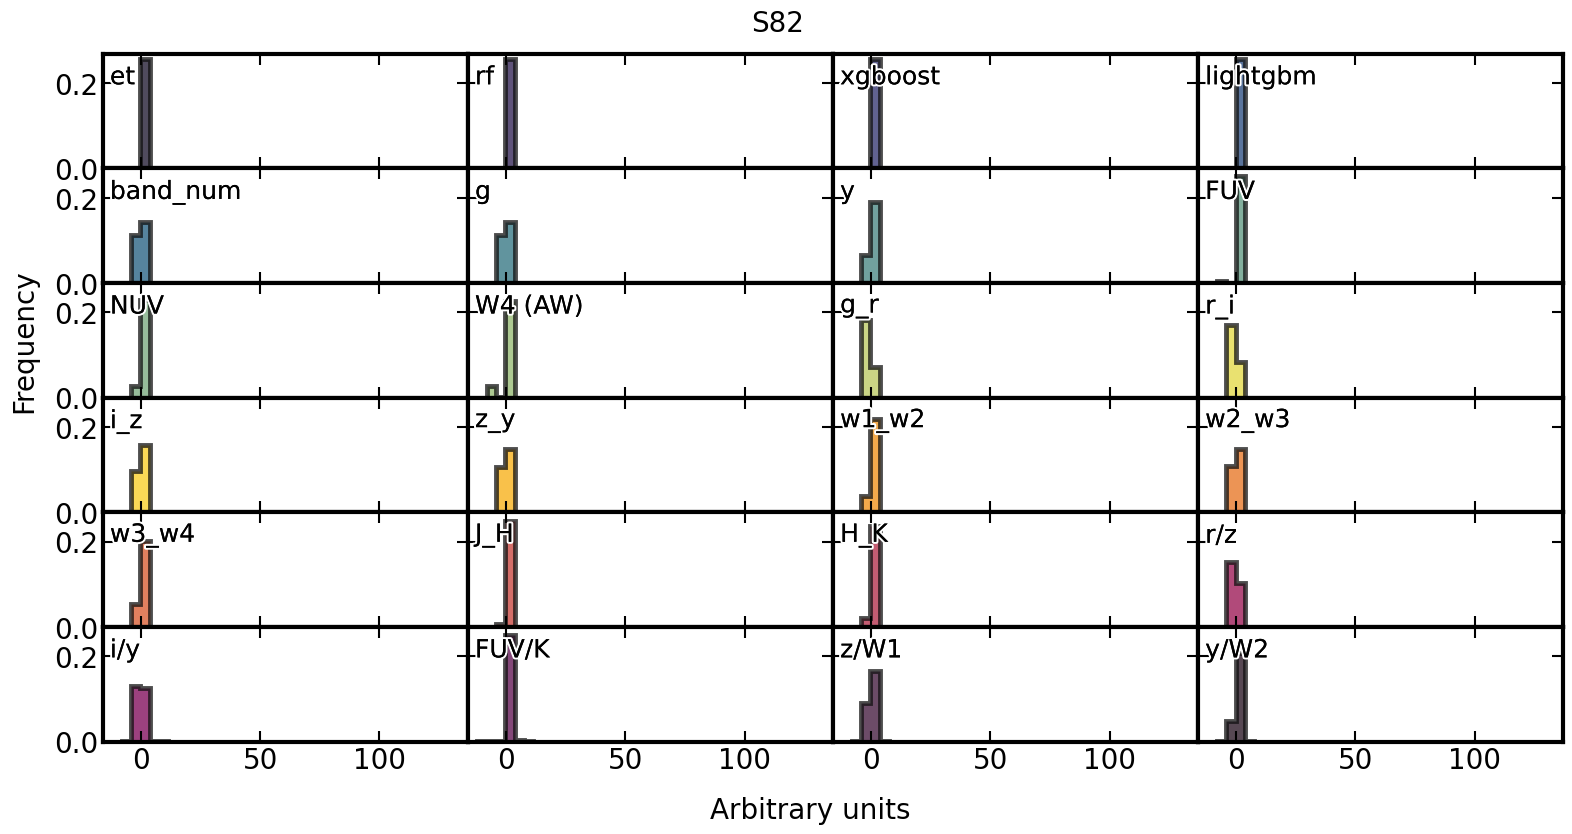

In [107]:
if run_AGN_analysis:
    n_cols = 4
    n_rows = int(np.ceil((len(reduced_cols_AGN)) / 4))

    min_feature     = reduced_data_AGN_df.loc[known_sources].min().min()
    max_feature     = reduced_data_AGN_df.loc[known_sources].max().max()
    feat_bins       = np.linspace(min_feature, max_feature, 40)

    fig             = plt.figure(figsize=(4 * n_cols, 1.4 * n_rows), constrained_layout=False)

    grid            = fig.add_gridspec(ncols=n_cols, nrows=n_rows, width_ratios=[1]*n_cols,
                                       height_ratios=[1]*n_rows, hspace=0.0, wspace=0.0)
    axs             = {}
    cmap_name       = 'cmr.pride'  # 'cmr.pride', 'cet_CET_R1'

    for count, feat in enumerate(reduced_cols_AGN):
        if count == 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         xscale='linear', yscale='linear')
        elif count != 0:
            axs[count] = fig.add_subplot(grid[int(np.floor(count / n_cols)), int(count % n_cols)],
                                         sharex=axs[0], sharey=axs[0])

        # filt_lims = np.array(full_catalog_df.loc[:, feat] != mag_cols_lim[feat])
        axs[count].hist(reduced_data_AGN_df.loc[known_sources, feat], bins=feat_bins, histtype='stepfilled',
                        ec='k', lw=3.5, fc=plt.get_cmap(cmap_name, len(reduced_cols_AGN))(count),
                        alpha=0.75, label=f'{feat}', density=True)

        axs[count].tick_params(which='both', top=True, right=True, direction='in')
        axs[count].tick_params(axis='both', which='major', labelsize=20)
        axs[count].tick_params(which='major', length=8, width=1.5)
        axs[count].tick_params(which='minor', length=4, width=1.5)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        plt.setp(axs[count].spines.values(), linewidth=3.0)
        #axs[count].grid(zorder=0)
        if count % n_cols != 0:
            plt.setp(axs[count].get_yticklabels(), visible=False)
        # if np.ceil((count + 1) / n_cols) != n_rows:
        #     plt.setp(axs[count].get_xticklabels(), visible=False)
        if count < (len(reduced_cols_AGN) - n_cols):
            plt.setp(axs[count].get_xticklabels(), visible=False)
        try:
            feat_name_str = feat_cols_names[feat]
        except:
            feat_name_str = feat
        axs[count].annotate(text=f'{feat_name_str}', xy=(0.02, 0.9),\
                             xycoords='axes fraction', fontsize=18, ha='left', va='top', path_effects=pe2)
        #axs[count].annotate(text=f'N={np.sum(filt_lims):,}', xy=(0.98, 0.9),\
        #                     xycoords='axes fraction', fontsize=18, ha='right', va='top', path_effects=pe2)
        axs[0].set_xlim(left=np.floor(min_feature), right=np.ceil(max_feature))
        # axs[0].set_xlim(left=np.floor(min_feature), right=15)
        # axs[0].invert_xaxis()
        # axs[count].legend(loc=2)
    
    if used_area != 'HETDEX':
        sup_title = used_area
        area_save = used_area
    elif used_area == 'HETDEX':
        sup_title = f'{used_area} - {HETDEX_subset}'
        area_save = f'{used_area}_{HETDEX_subset}'
    fig.suptitle(sup_title, fontsize=20)
    fig.supxlabel('Arbitrary units', fontsize=20, x=0.52)
    fig.supylabel('Frequency', fontsize=20, va='bottom')

    fig.tight_layout()
    if save_plot_flag:
        plt.savefig(f'plots/hists_transf_feats_AGN_gal_pipe_{area_save}.pdf', bbox_inches='tight')
    plt.show()

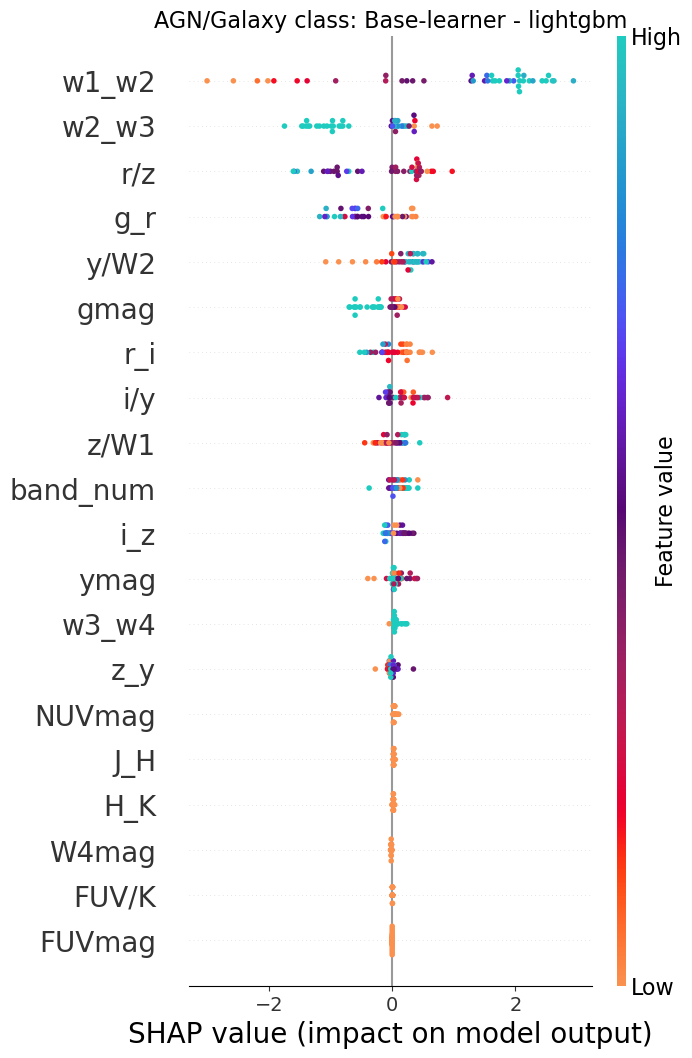

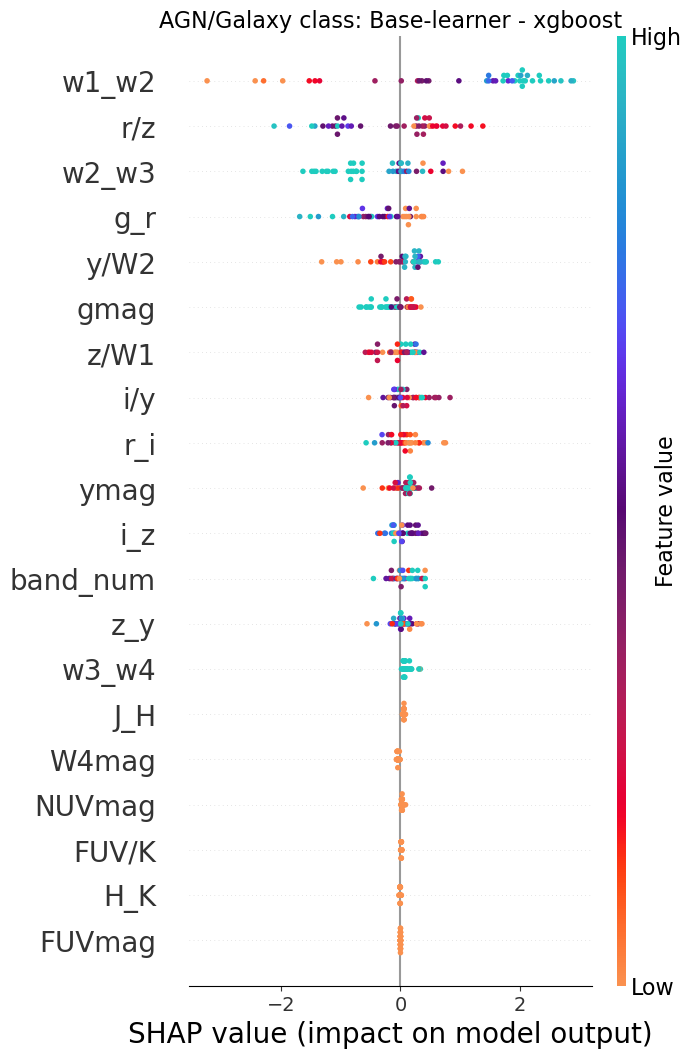

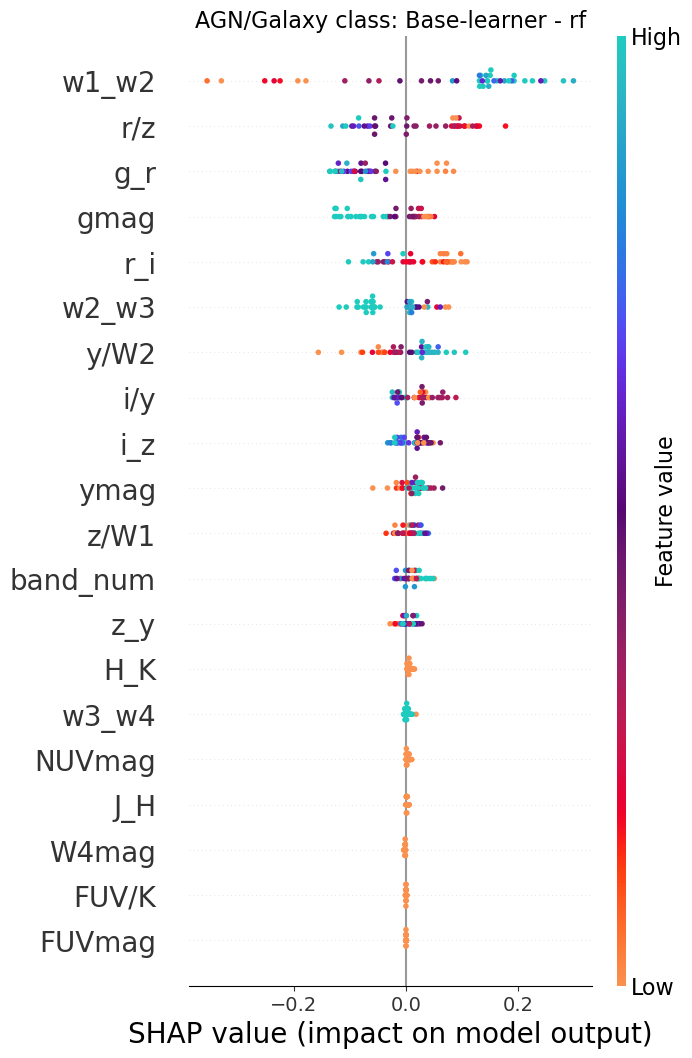

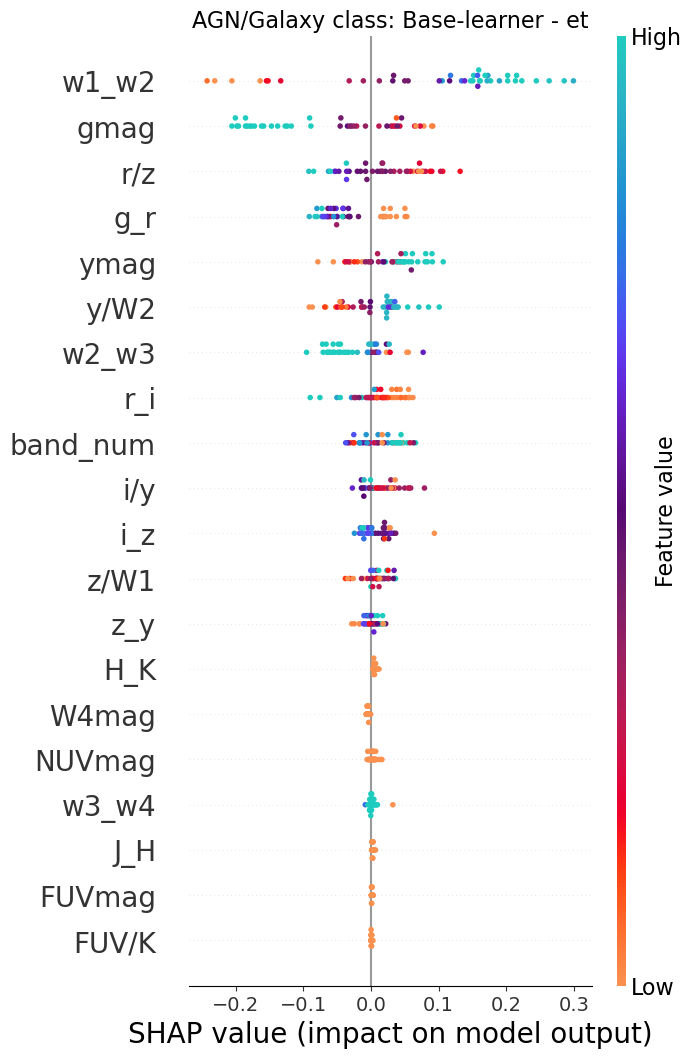

In [42]:
if run_AGN_analysis:
    for model in shap_values_AGN_base.keys():
        plot_shap_beeswarm('AGN/Galaxy class', model, shap_values_AGN_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

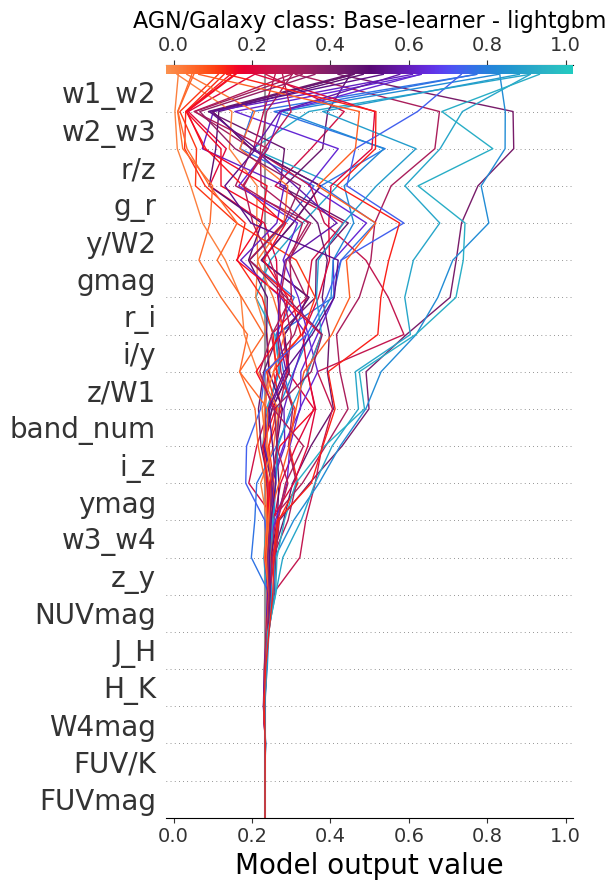

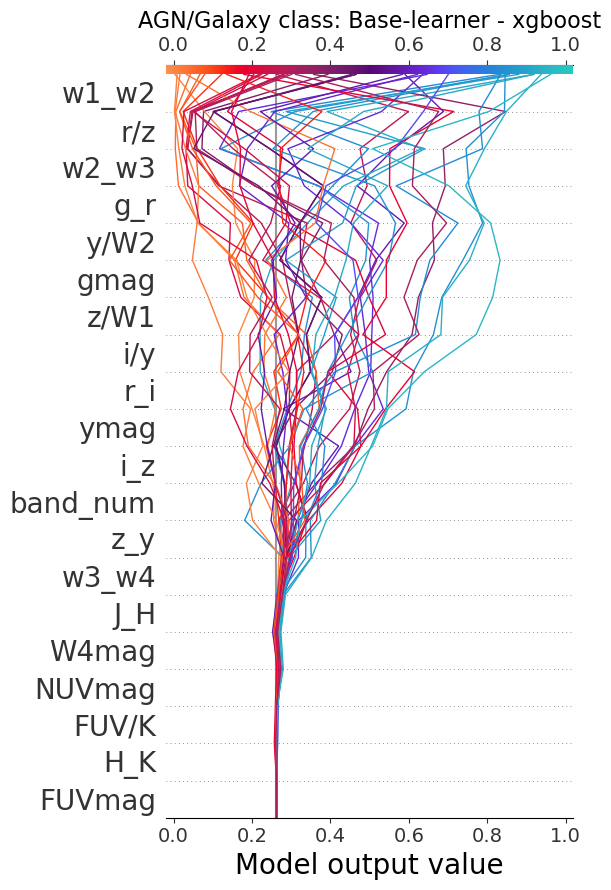

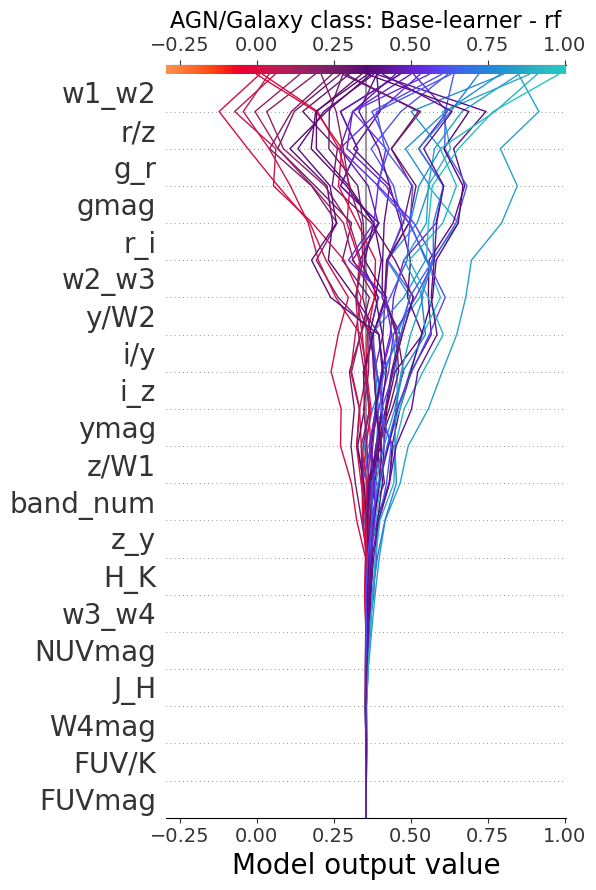

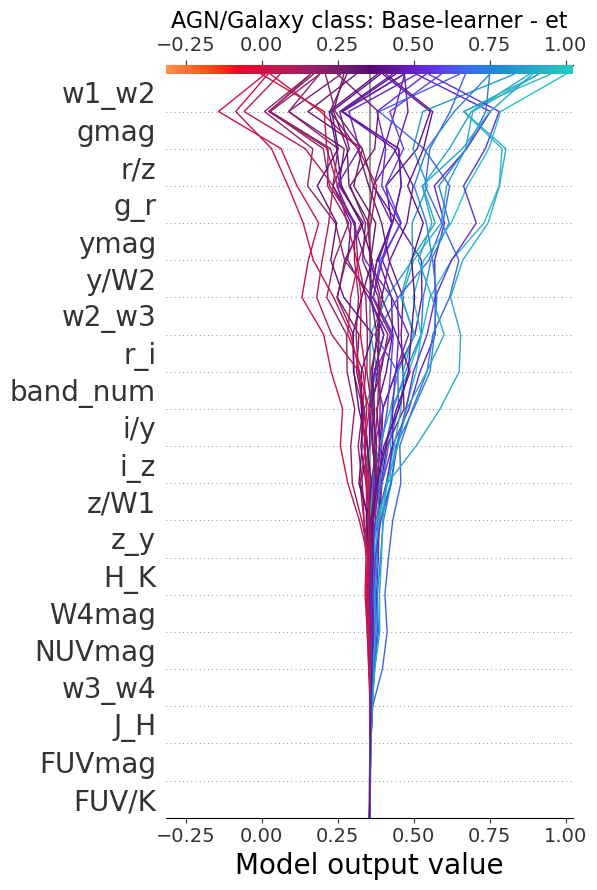

In [43]:
if run_AGN_analysis:
    for model in shap_values_AGN_base.keys():
        size_side       = 6
        if model in ['lightgbm', 'xgboost', 'catboost']:
            logit_mode = 'logit'
        else:
            logit_mode = 'identity'
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('AGN/Galaxy class', model, shap_values_AGN_base[model], explainers_AGN_base[model],\
                           reduced_cols_AGN_base, ax1, logit_mode, new_base_value=None)
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_AGN_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [44]:
if run_AGN_analysis:
    for count, model in enumerate(shap_values_AGN_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(AGN_gal_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_AGN_df.drop(columns=estimators_list_AGN))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((np.array([explainers_AGN_base[model].expected_value]).flatten()[-1] + shap_values_AGN_base[model].values[0].sum()).round(5))


lightgbm:
0
-0.79816

xgboost:
0
-1.03389

rf:
0
0.35532

et:
0
0.3553


---

#### SHAP - Radio detection model

In [45]:
if run_radio_analysis:
    model_name_radio = type(radio_det_clf.named_steps['trained_model'].final_estimator_).__name__.replace('Classifier', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [46]:
if run_radio_analysis:
    sample_size_radio   = 1000
    if run_high_z_flag:
        filter_pred_AGN = np.ones_like(full_catalog_df.loc[:, 'pred_class']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_AGN = np.array(full_catalog_df.loc[:, 'pred_class'] == 1) & filter_pred_no_str
    sample_size_radio   = np.nanmin([sample_size_radio, np.sum(filter_selection * filter_pred_AGN)])
    print(f'Number of selected elements: {sample_size_radio:,}')

Number of selected elements: 42


In [47]:
if run_radio_analysis:
    estimators_list_radio   = get_base_estimators_names(radio_det_clf)

In [48]:
if run_radio_analysis:
    reduced_data_radio      = full_catalog_df.loc[filter_selection,\
                                                  get_final_column_names(radio_det_clf, full_catalog_df)].sample(n=sample_size_radio, random_state=seed).copy()
    reduced_idx_radio       = reduced_data_radio.index
    reduced_cols_radio_base = reduced_data_radio.columns
    reduced_cols_radio      = reduced_data_radio.columns.insert(0, estimators_list_radio[0])
    if len(estimators_list_radio) > 1:
        for est_name in estimators_list_radio[1::]:
            reduced_cols_radio = reduced_cols_radio.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [49]:
if run_radio_analysis:
    print('Running data pre-processing:\n')
    if isinstance(radio_det_clf, sklearn.pipeline.Pipeline):
        prep_steps = radio_det_clf.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_radio = method.transform(reduced_data_radio)
    reduced_data_radio_df = pd.DataFrame(reduced_data_radio, columns=reduced_cols_radio, index=reduced_idx_radio)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [50]:
if run_radio_analysis:
    explainers_radio_base           = {}
    for model, model_fit in zip(radio_det_clf.named_steps['trained_model'].estimators, radio_det_clf.named_steps['trained_model'].estimators_):
        explainers_radio_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                     model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [51]:
if run_radio_analysis:
    shap_values_radio_base = {}
    for model in explainers_radio_base.keys():
        print(f'Working with base model {model}')
        shap_values_radio_base[model] = explainers_radio_base[model](reduced_data_radio_df.drop(columns=estimators_list_radio))

Working with base model dt
Working with base model rf
Working with base model xgboost
Working with base model et


In [52]:
if run_radio_analysis:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_radio_base.keys():
        print(f'{model: <10}\t: {explainers_radio_base[model].expected_value[-1]: .4f}')

Expected "logit" values per base model
------------------------------
dt        	:  0.3260
rf        	:  0.3260
xgboost   	: -0.8362
et        	:  0.3260


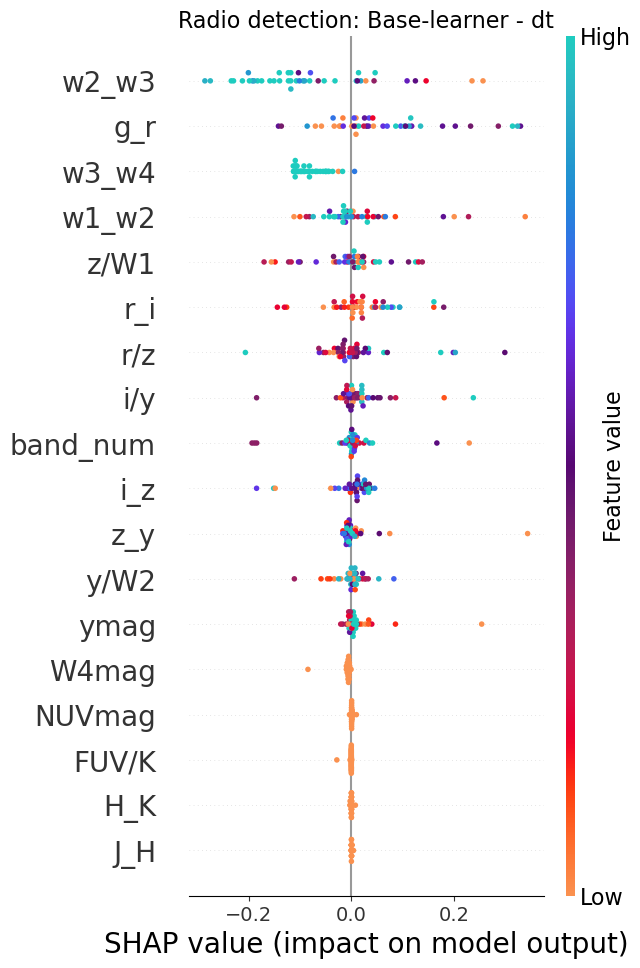

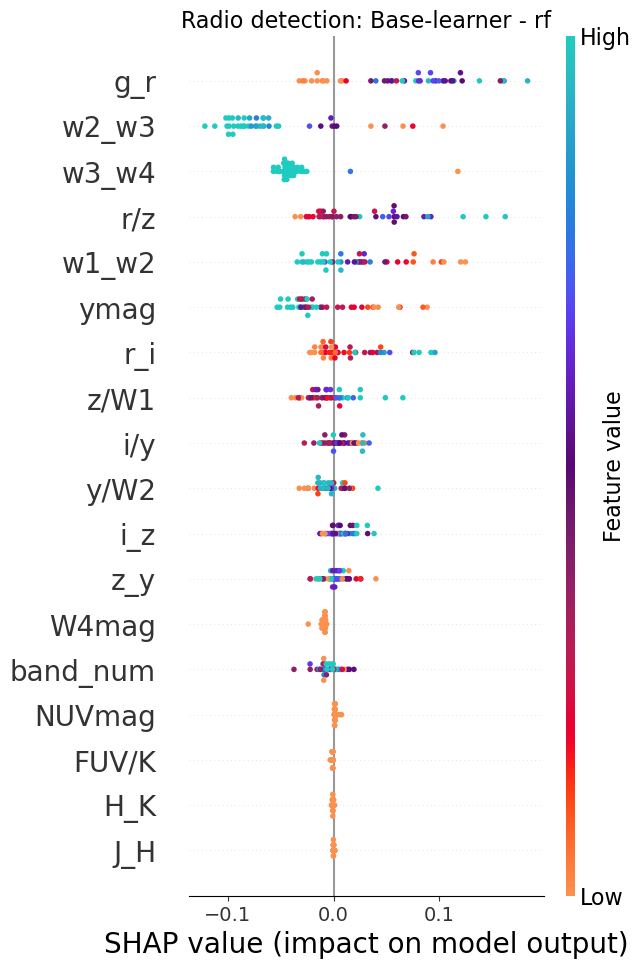

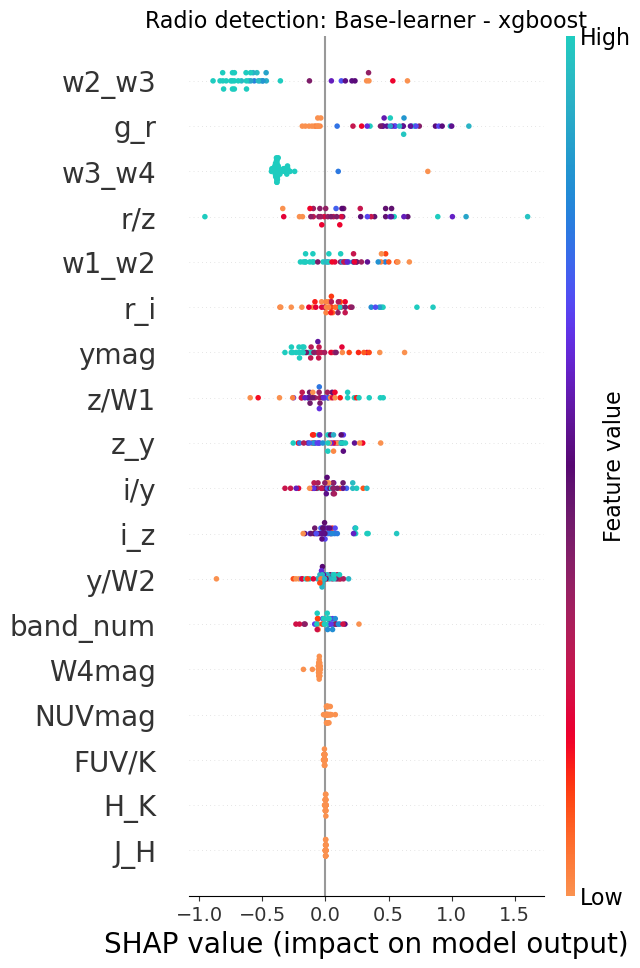

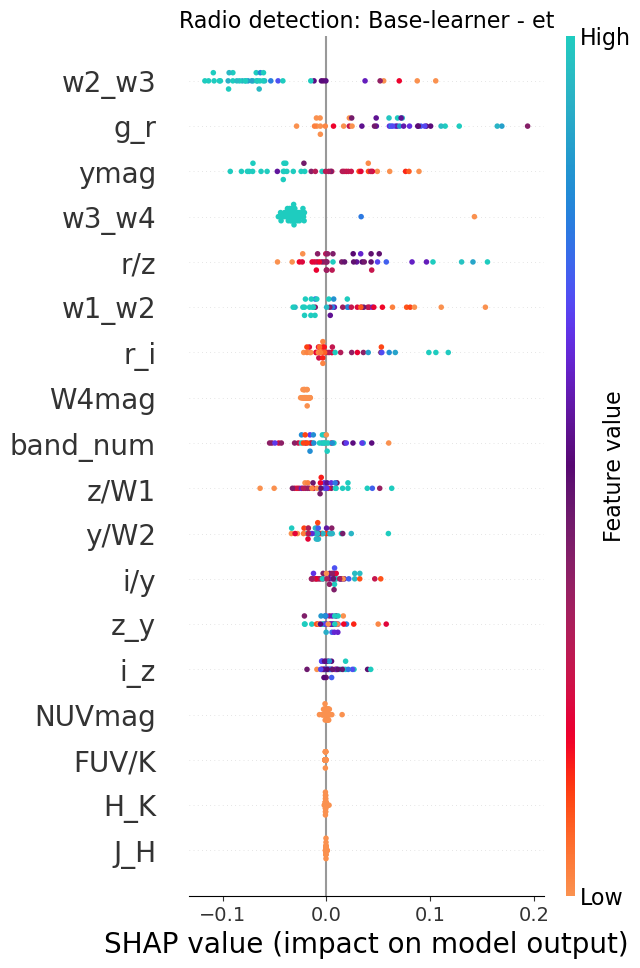

In [53]:
if run_radio_analysis:
    for model in shap_values_radio_base.keys():
        plot_shap_beeswarm('Radio detection', model, shap_values_radio_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

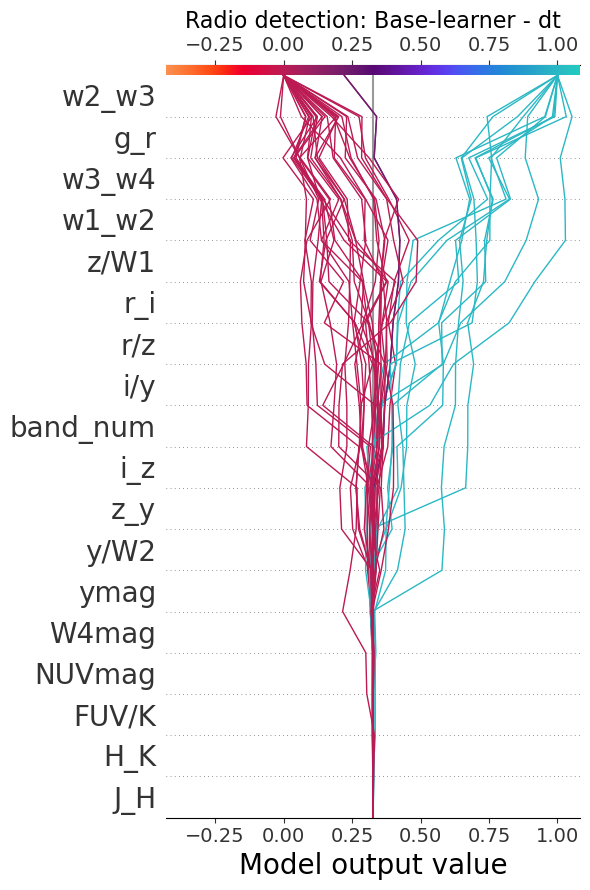

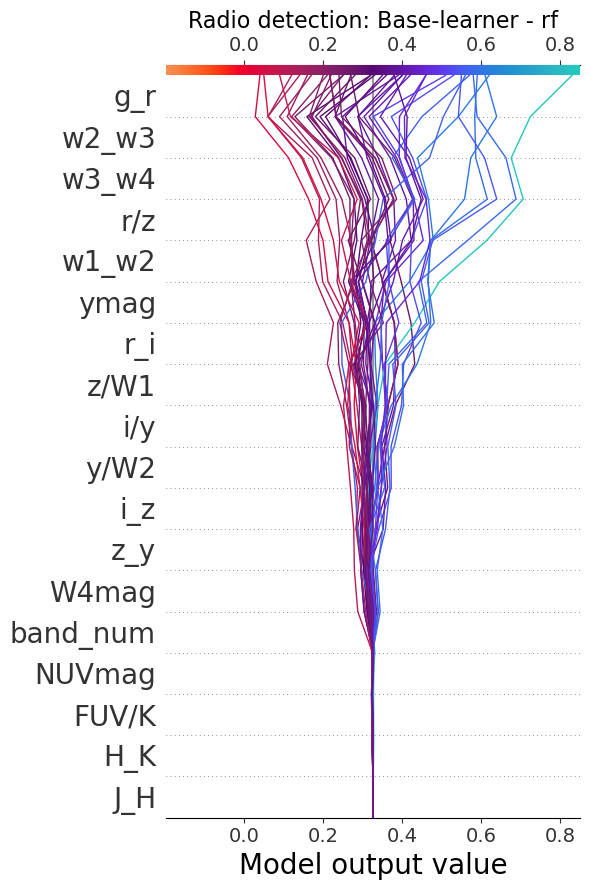

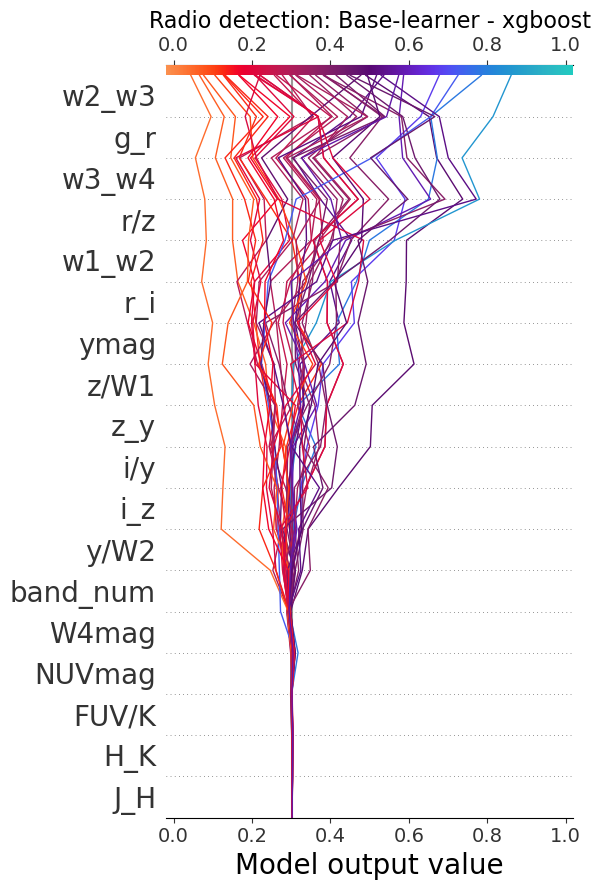

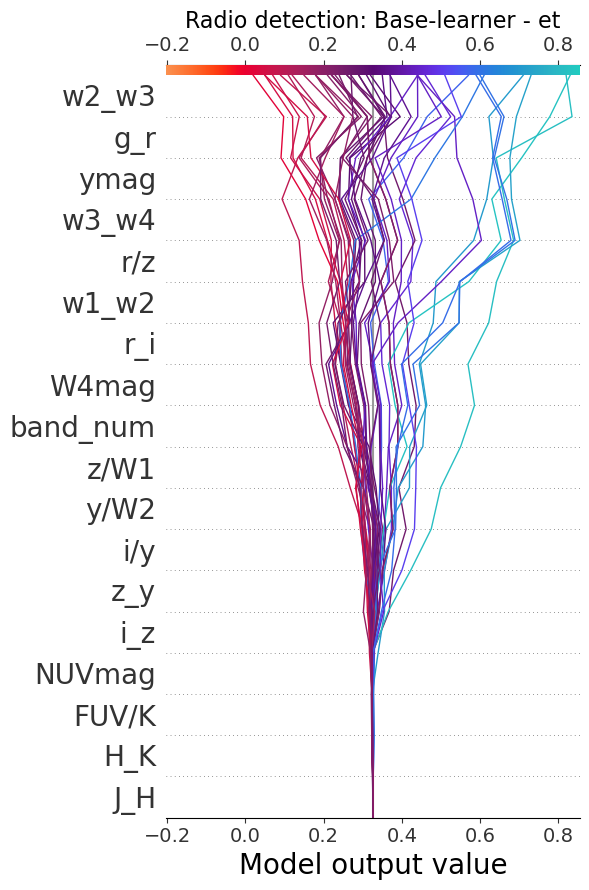

In [54]:
if run_radio_analysis:
    for model in shap_values_radio_base.keys():
        size_side       = 6
        if model in ['lightgbm', 'xgboost', 'catboost']:
            logit_mode = 'logit'
        else:
            logit_mode = 'identity'
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('Radio detection', model, shap_values_radio_base[model], explainers_radio_base[model], reduced_cols_radio_base, ax1, logit_mode)
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_radio_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [55]:
if run_radio_analysis:
    for count, model in enumerate(shap_values_radio_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(radio_det_clf.named_steps['trained_model'].estimators_[count].predict(reduced_data_radio_df.drop(columns=estimators_list_radio))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        print((explainers_radio_base[model].expected_value[-1] + shap_values_radio_base[model].values[0].sum()).round(5))


dt:
0
0.32597

rf:
0
0.32604

xgboost:
0
-0.86307

et:
0
0.32597


---

#### SHAP - First redshift prediction model

In [56]:
if run_z_analysis:
    model_name_z = type(redshift_reg.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [57]:
if run_z_analysis:
    sample_size_z        = 1000
    if run_high_z_flag:
        filter_pred_rAGN = np.ones_like(full_catalog_df.loc[:, 'pred_radio_AGN']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_rAGN = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1)
    sample_size_z        = np.nanmin([sample_size_z, np.sum(filter_selection * filter_pred_rAGN)])
    print(f'Number of selected elements: {sample_size_z:,}')

Number of selected elements: 42


In [58]:
if run_z_analysis:
    estimators_list_z = get_base_estimators_names(redshift_reg)

In [59]:
if run_z_analysis:
    reduced_data_z      = full_catalog_df.loc[filter_selection,\
                                              get_final_column_names(redshift_reg, full_catalog_df)].sample(n=sample_size_z, random_state=seed).copy()
    reduced_idx_z       = reduced_data_z.index
    reduced_cols_z      = reduced_data_z.columns
    reduced_cols_z_base = reduced_data_z.columns
    reduced_cols_z      = reduced_data_z.columns.insert(0, estimators_list_z[0])
    if len(estimators_list_z) > 1:
        for est_name in estimators_list_z[1::]:
            reduced_cols_z = reduced_cols_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [60]:
if run_z_analysis:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_z = method.transform(reduced_data_z)
    reduced_data_z_df = pd.DataFrame(reduced_data_z, columns=reduced_cols_z, index=reduced_idx_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [61]:
if run_z_analysis:
    explainers_z_base           = {}
    for model, model_fit in zip(redshift_reg.named_steps['trained_model'].estimators, redshift_reg.named_steps['trained_model'].estimators_):
        explainers_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                 model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [62]:
if run_z_analysis:
    shap_values_z_base = {}
    for model in explainers_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_z_base[model] = explainers_z_base[model](reduced_data_z_df.drop(columns=estimators_list_z))

Working with base model et
Working with base model lightgbm
Working with base model catboost
Working with base model dt


In [63]:
if run_z_analysis:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
et        	:  1.2862
lightgbm  	:  1.2862
catboost  	:  1.2862
dt        	:  1.2862


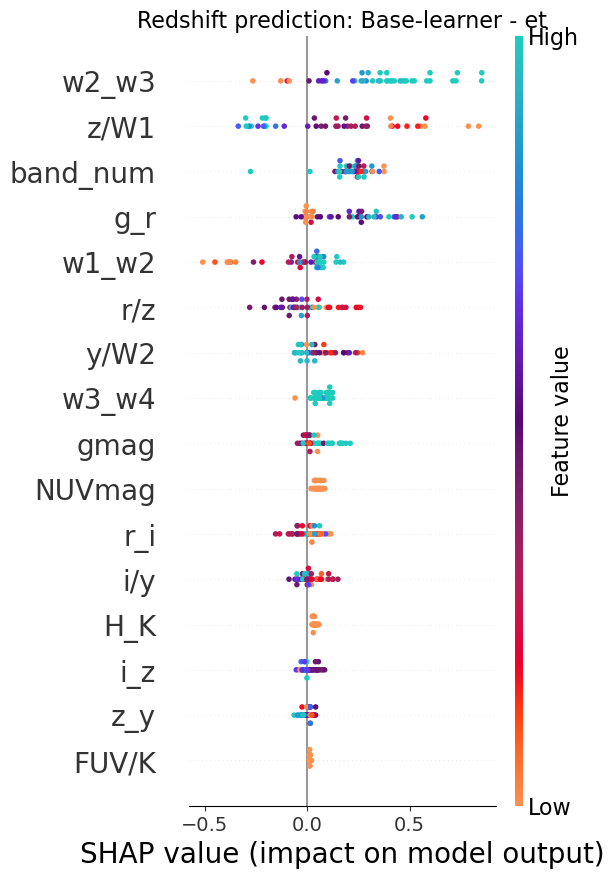

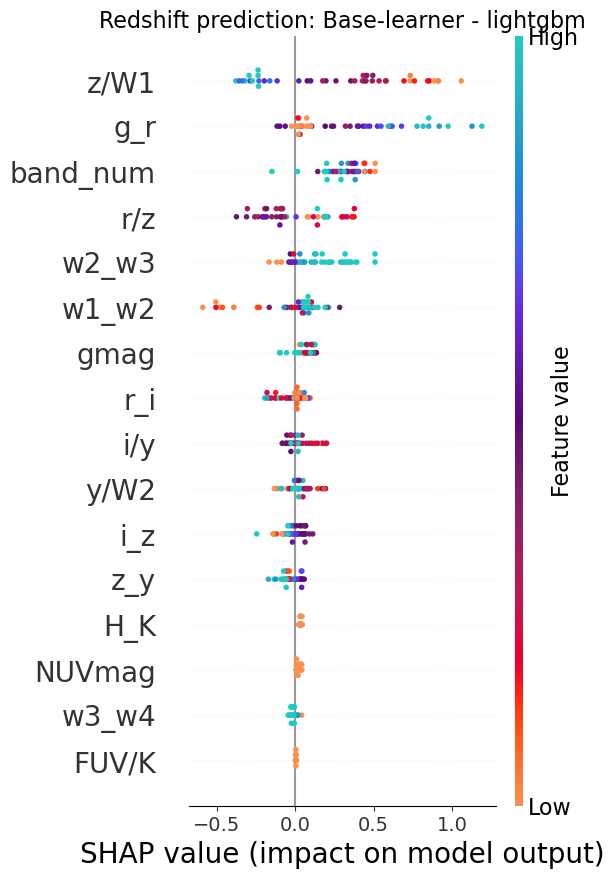

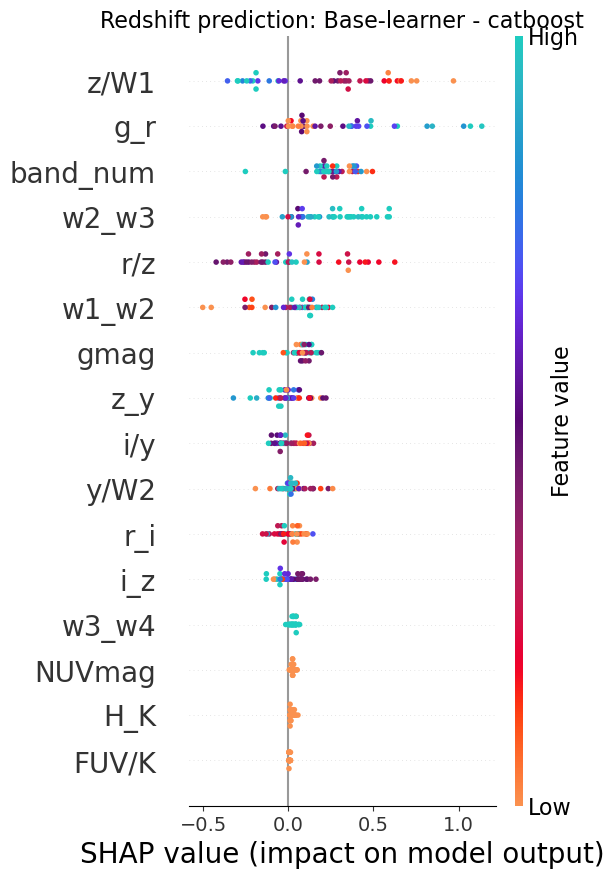

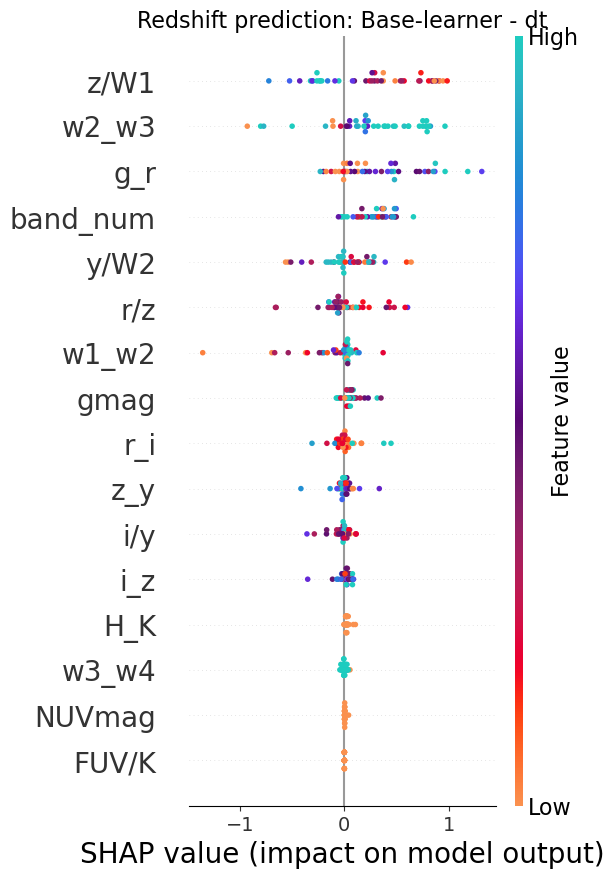

In [64]:
if run_z_analysis:
    for model in shap_values_z_base.keys():
        plot_shap_beeswarm('Redshift prediction', model, shap_values_z_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

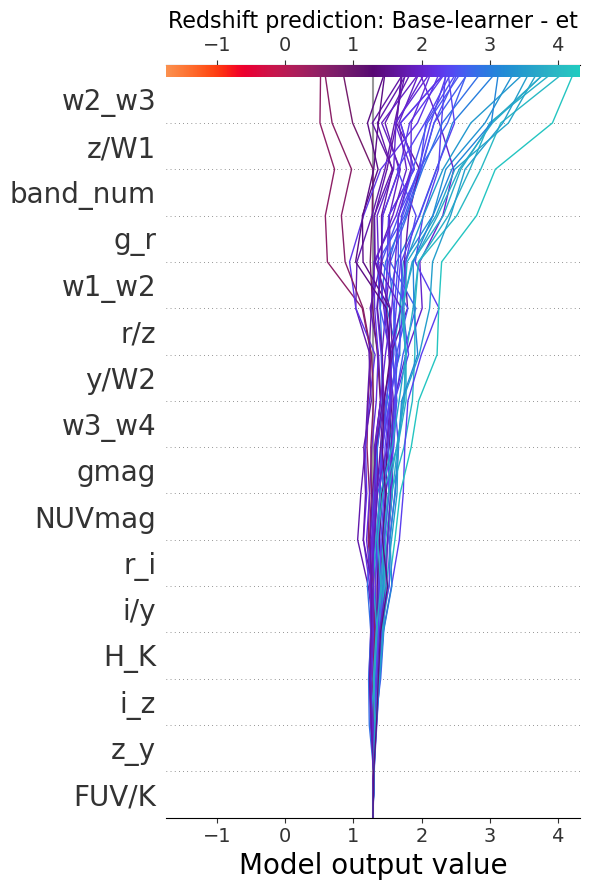

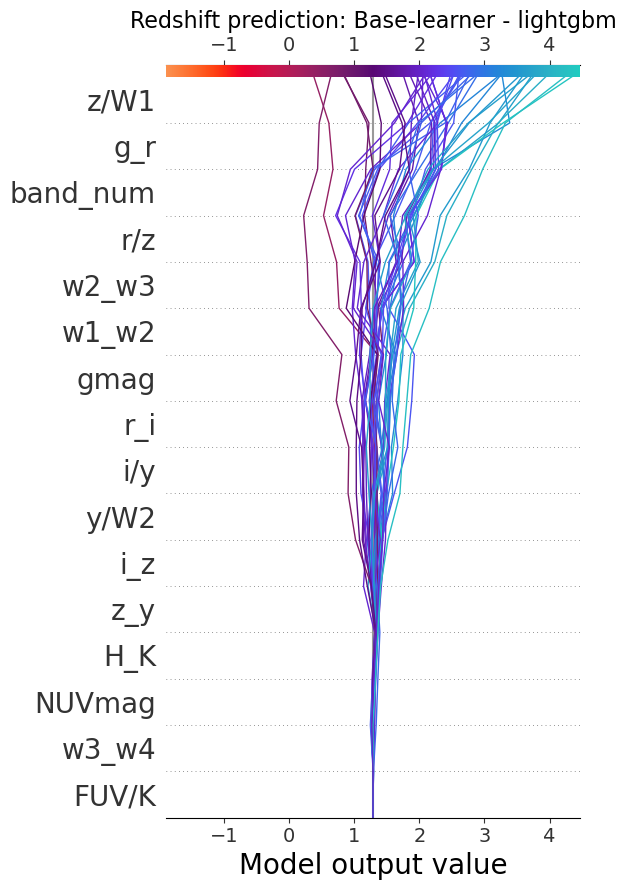

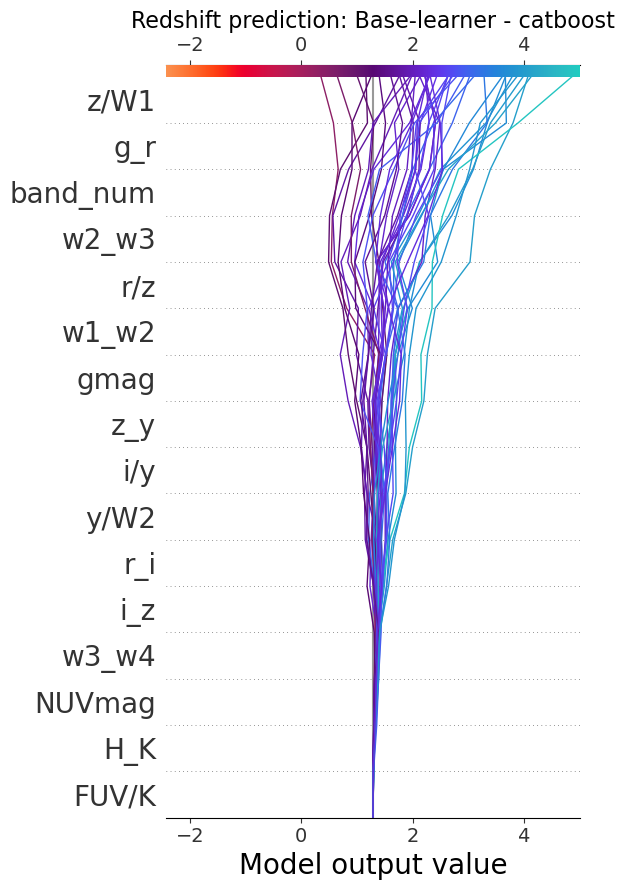

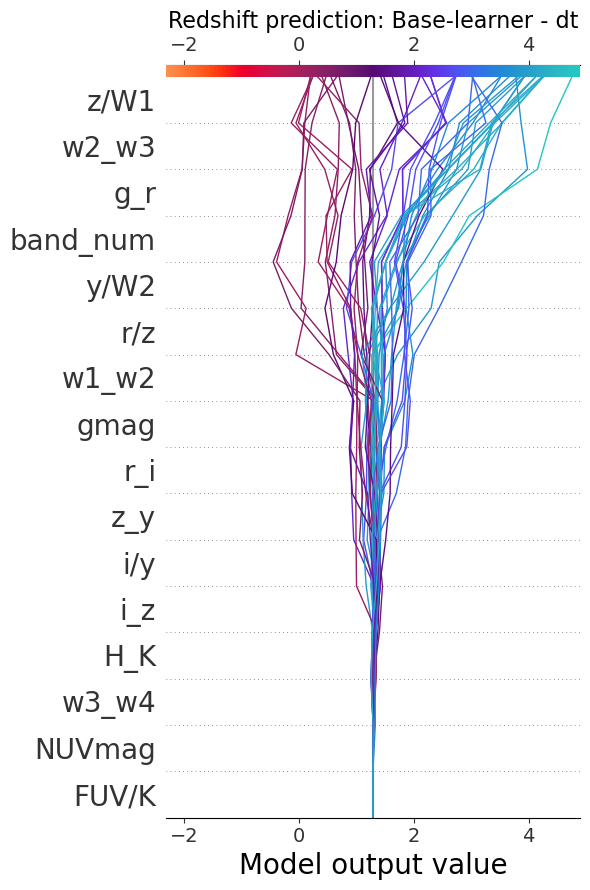

In [65]:
if run_z_analysis:
    for model in shap_values_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('Redshift prediction', model, shap_values_z_base[model], explainers_z_base[model], reduced_cols_z_base, ax1, 'identity')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [66]:
if run_z_analysis:
    for count, model in enumerate(shap_values_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg.named_steps['trained_model'].estimators_[count].predict(reduced_data_z_df.drop(columns=estimators_list_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_z_base[model].expected_value[-1] + shap_values_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_z_base[model].expected_value + shap_values_z_base[model].values[0].sum()).round(5))


et:
2.64582
2.64582

lightgbm:
2.63221
2.63221

catboost:
2.42846
2.42846

dt:
3.91
3.91


---

#### SHAP - Second redshift prediction model

In [67]:
if run_high_z_analysis:
    model_name_high_z = type(redshift_reg_2.named_steps['trained_model'].final_estimator_).__name__.replace('Regressor', '')

SHAP does not need to use the full dataset for its analysis. Around $N=1000$ is a good number.

In [68]:
if run_high_z_analysis:
    sample_size_high_z          = 1000
    if run_high_z_flag:
        filter_pred_rAGN_high_z = np.ones_like(full_catalog_df.loc[:, 'pred_Z']).astype(bool)
    elif not run_high_z_flag:
        filter_pred_rAGN_high_z = np.array(full_catalog_df.loc[:, 'pred_radio_AGN'] == 1) &\
                                    np.array(full_catalog_df.loc[:, 'pred_Z'] >= (redshift_lim + redshift_tol))
    sample_size_high_z          = np.nanmin([sample_size_high_z, np.sum(filter_selection * filter_pred_rAGN_high_z)])
    print(f'Number of selected elements: {sample_size_high_z:,}')

Number of selected elements: 42


In [69]:
if run_high_z_analysis:
    estimators_list_high_z = get_base_estimators_names(redshift_reg_2)

In [70]:
if run_high_z_analysis:
    reduced_data_high_z      = full_catalog_df.loc[filter_selection,\
                                                   get_final_column_names(redshift_reg_2, full_catalog_df)].sample(n=sample_size_high_z, random_state=seed).copy()
    reduced_idx_high_z       = reduced_data_high_z.index
    reduced_cols_high_z_base = reduced_data_high_z.columns
    reduced_cols_high_z      = reduced_data_high_z.columns.insert(0, estimators_list_high_z[0])
    if len(estimators_list_high_z) > 1:
        for est_name in estimators_list_high_z[1::]:
            reduced_cols_high_z = reduced_cols_high_z.insert(0, est_name)

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names


In [71]:
if run_high_z_analysis:
    print('Running data pre-processing:\n')
    if isinstance(redshift_reg_2, sklearn.pipeline.Pipeline):
        prep_steps = redshift_reg_2.named_steps.items()
    else:
        prep_steps = pyc.get_config('prep_pipe').named_steps.items()
    
    for (name, method) in prep_steps:
        if method != 'passthrough':  # and name != 'trained_model':
            print(f'Running {name}')
            reduced_data_high_z = method.transform(reduced_data_high_z)
    reduced_data_high_z_df = pd.DataFrame(reduced_data_high_z, columns=reduced_cols_high_z, index=reduced_idx_high_z)

Running data pre-processing:

Running dtypes
Running imputer
Running new_levels1
Running new_levels
Running feature_time
Running scaling
Running P_transform
Running dummy
Running fix_perfect
Running clean_names
Running trained_model


Use FastTreeSHAP package

In [72]:
if run_high_z_analysis:
    explainers_high_z_base           = {}
    for model, model_fit in zip(redshift_reg_2.named_steps['trained_model'].estimators, redshift_reg_2.named_steps['trained_model'].estimators_):
        explainers_high_z_base[model[0]] = fasttreeshap.TreeExplainer(model_fit, data=None, feature_perturbation='tree_path_dependent',\
                                                                      model_output='raw', feature_dependence='independent', algorithm='auto', n_jobs=12)

In [73]:
if run_high_z_analysis:
    shap_values_high_z_base = {}
    for model in explainers_high_z_base.keys():
        print(f'Working with base model {model}')
        shap_values_high_z_base[model] = explainers_high_z_base[model](reduced_data_high_z_df.drop(columns=estimators_list_high_z))

Working with base model et
Working with base model dt
Working with base model catboost
Working with base model gbr


In [74]:
if run_high_z_analysis:
    print('Expected "logit" values per base model')
    print('-' * 30)
    for model in explainers_high_z_base.keys():
        try:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value[-1]: .4f}')
        except:
            print(f'{model: <10}\t: {explainers_high_z_base[model].expected_value: .4f}')

Expected "logit" values per base model
------------------------------
et        	:  4.5360
dt        	:  4.5360
catboost  	:  4.5360
gbr       	:  4.5360


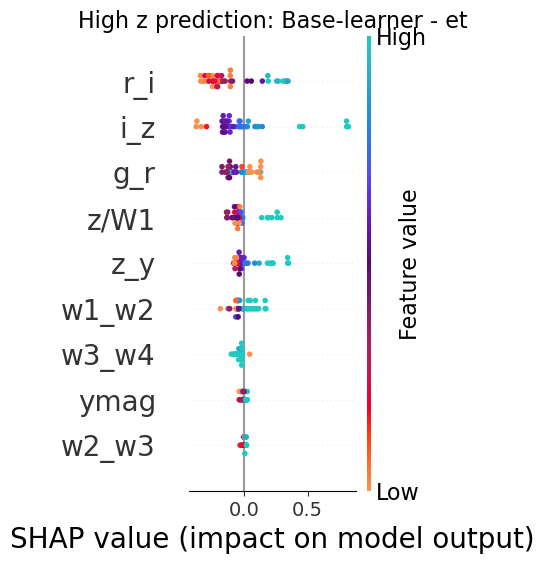

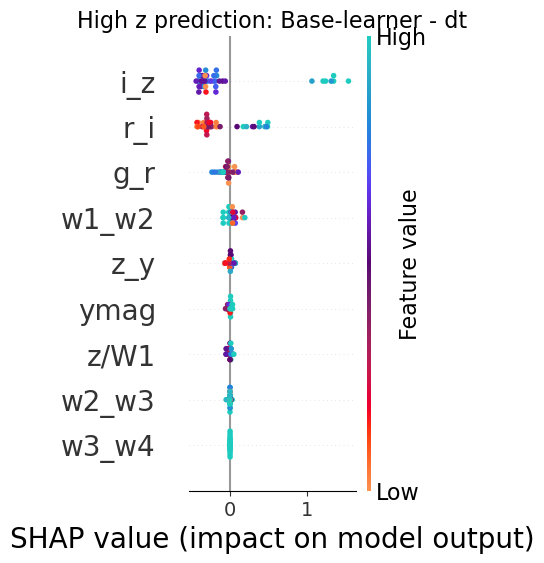

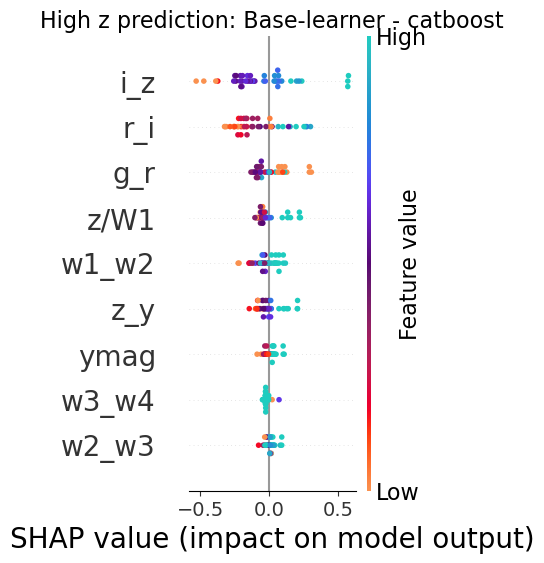

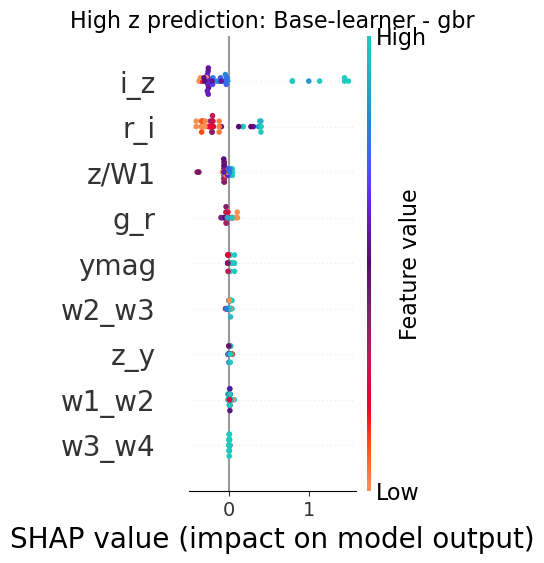

In [75]:
if run_high_z_analysis:
    for model in shap_values_high_z_base.keys():
        plot_shap_beeswarm('High z prediction', model, shap_values_high_z_base[model])
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

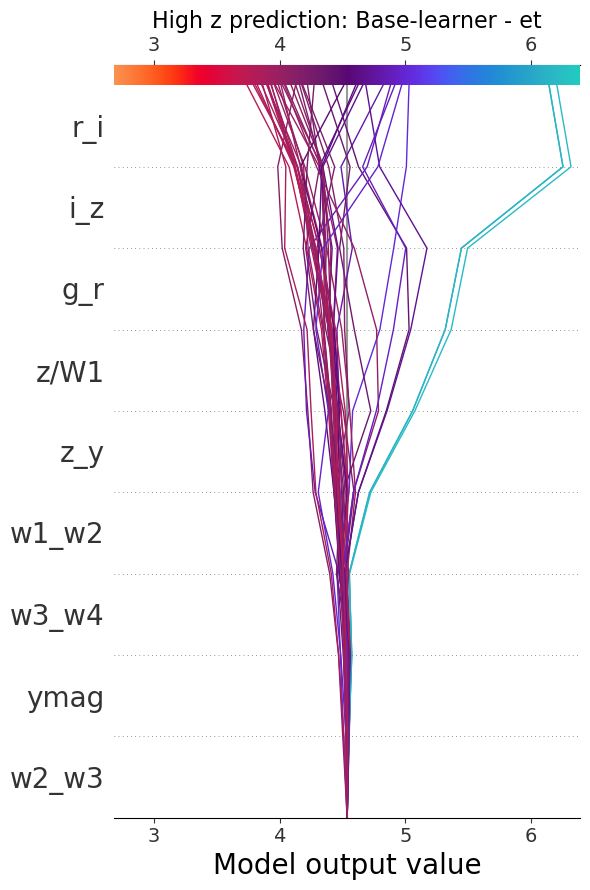

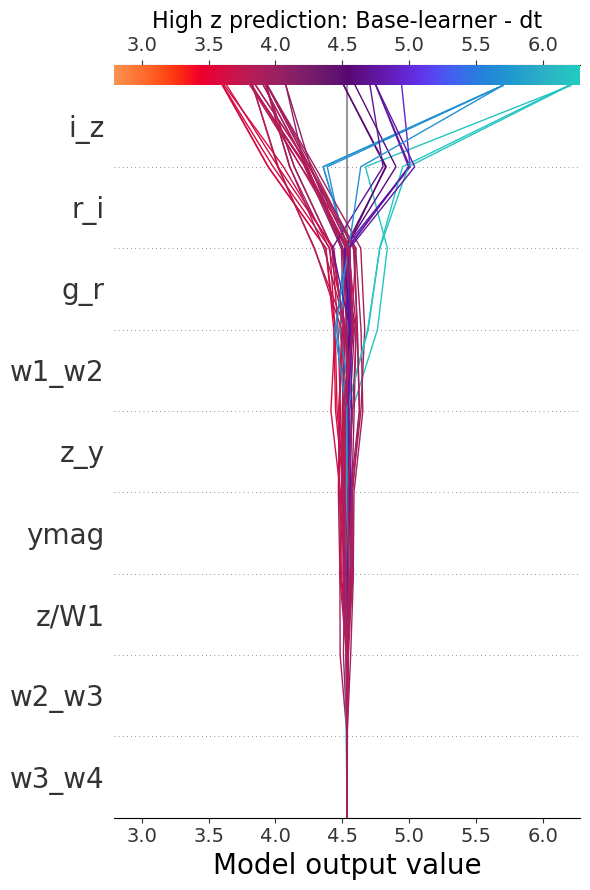

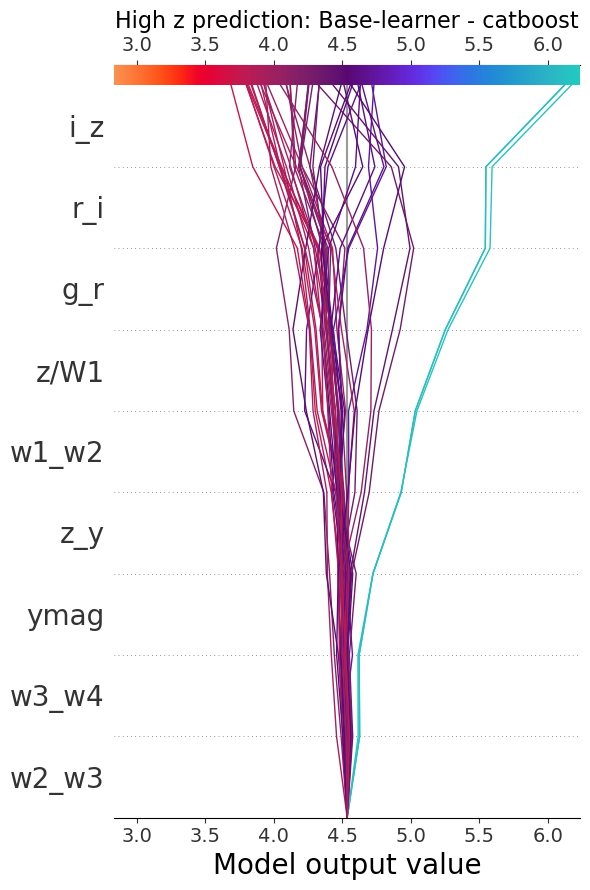

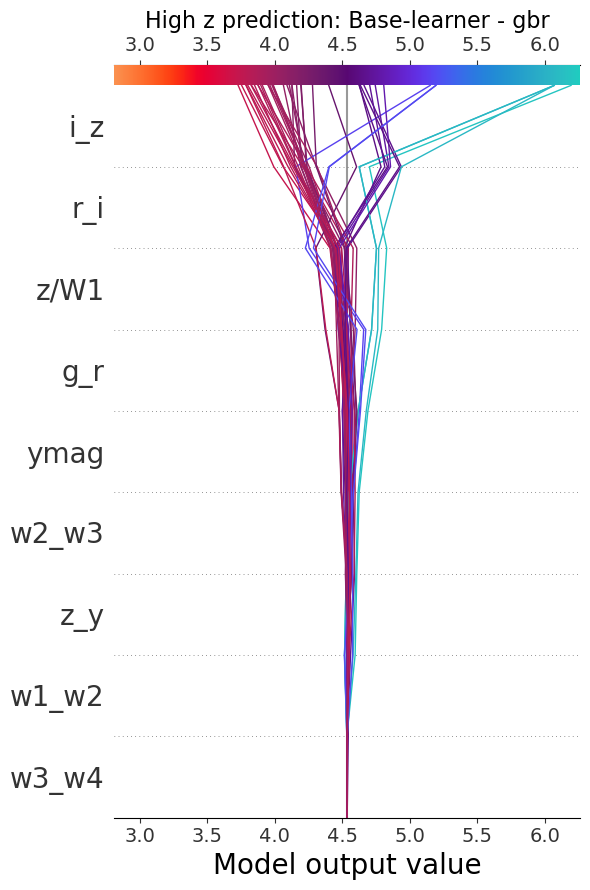

In [76]:
if run_high_z_analysis:
    for model in shap_values_high_z_base.keys():
        size_side       = 6
        fig             = plt.figure(figsize=(size_side, size_side * 3/2))
        ax1             = fig.add_subplot(111, xscale='linear', yscale='linear')
        plot_shap_decision('High z prediction', model, shap_values_high_z_base[model],\
                           explainers_high_z_base[model], reduced_cols_high_z_base, ax1, 'identity')
        if save_plot_flag:
            plt.savefig(f'plots/SHAP_decision_high_z_base_{model}_{used_area}.pdf', bbox_inches='tight')
        plt.show()

In [77]:
if run_high_z_analysis:
    for count, model in enumerate(shap_values_high_z_base.keys()):
        print(f'\n{model}:')
        # The model's raw prediction for the first observation.
        print(redshift_reg_2.named_steps['trained_model'].estimators_[count].predict(reduced_data_high_z_df.drop(columns=estimators_list_high_z))[0].round(5))
    
        # The corresponding sum of the mean + shap values
        try:
            print((explainers_high_z_base[model].expected_value[-1] + shap_values_high_z_base[model].values[0].sum()).round(5))
        except:
            print((explainers_high_z_base[model].expected_value + shap_values_high_z_base[model].values[0].sum()).round(5))


et:
3.89943
3.89943

dt:
3.91
3.91

catboost:
3.84246
3.84246

gbr:
3.89598
3.89598
